<a href="https://colab.research.google.com/github/Arnie-He/DL-Seminar/blob/main/mini_project_flow_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stencil code for Mini Project Flow Matching. **Please make a copy before modifying the code.**

Created by Calvin Luo (calvin_luo@brown.edu)

## Imports and Set Up Code

👀 This should look suspiciously familiar from the [Score Matching miniproject from 2470 (CSCI2470-MP3)](https://colab.research.google.com/drive/1kbE2z65keTOGgshnPhVDeVjs8uaD5dWP)!

In [ ]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
import tensorflow.keras.layers as tfkl
from tensorflow.keras.utils import Progbar

import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image

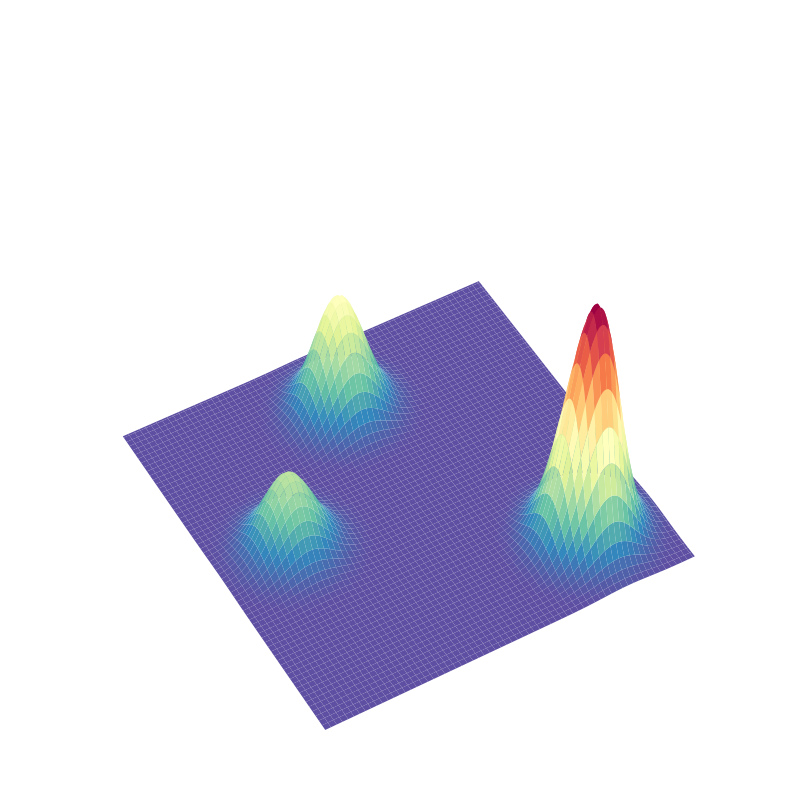

In [ ]:
### Set up Mixture of Gaussians
# Take a glance at the libraries and methods we call to make a Mixture of Gaussians!
pi = np.array([0.2, 0.3, 0.6], dtype=np.float32)
mu = np.array([[-5, 0],
               [0, 5],
               [5, -5]], dtype=np.float32)
sigma = np.array([[1, 1],
                  [1, 1],
                  [1, 1]], dtype=np.float32)
gmm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=pi),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=mu,
        scale_diag=sigma)
)

# Display Mixture of Gaussians
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1,1,1,projection='3d',aspect='auto')

N = 200
X = np.linspace(-8, 8, N)
Y = np.linspace(-8, 8, N)
X, Y = np.meshgrid(X, Y)
coords = tf.stack([X, Y], axis=-1)
Z = gmm.prob(tf.cast(coords, tf.float32))

ax1.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=0, antialiased=True,
                cmap=cm.Spectral_r, alpha=1.0)

ax1.view_init(50,-120)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])

color_tuple = (1.0, 1.0, 1.0, 0.0)

ax1.xaxis.set_pane_color(color_tuple)
ax1.yaxis.set_pane_color(color_tuple)
ax1.zaxis.set_pane_color(color_tuple)
ax1.xaxis.line.set_color(color_tuple)
ax1.yaxis.line.set_color(color_tuple)
ax1.zaxis.line.set_color(color_tuple)

plt.tight_layout()
plt.show()

In [ ]:
# Helper function to generate visualization GIFs.
def generate_gif(frames, fname='temp.gif', time_per_frame=125, final_frame_time=1000):
  # Pause the GIF at the end by extending the duration of the last frame
  duration = [time_per_frame] * (len(rendered)-1) + [final_frame_time]
  imageio.mimwrite(fname, rendered, loop=0, duration=duration)

# Helper function to visualize scatter points on 3d.
def scatter_3d(predicted_samples):
  rendered = []
  for i in range(len(predicted_samples)):

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1,1,1,projection='3d')

    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=0, antialiased=True,
                    cmap=cm.Spectral_r, alpha=0.5,label='_nolegend_')

    ax.view_init(50,-120)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    color_tuple = (1.0, 1.0, 1.0, 0.0)

    ax.xaxis.set_pane_color(color_tuple)
    ax.yaxis.set_pane_color(color_tuple)
    ax.zaxis.set_pane_color(color_tuple)
    ax.xaxis.line.set_color(color_tuple)
    ax.yaxis.line.set_color(color_tuple)
    ax.zaxis.line.set_color(color_tuple)

    mask = (predicted_samples[i][:,0] >= -8) & (predicted_samples[i][:,0] <= 8) & (predicted_samples[i][:,1] >= -8) & (predicted_samples[i][:,1] <= 8)
    x_masked = np.ma.masked_array(predicted_samples[i][:,0], ~mask)
    y_masked = np.ma.masked_array(predicted_samples[i][:,1], ~mask)
    z_masked = np.ma.masked_array(gmm.prob(predicted_samples[i]), ~mask)

    ax.scatter(x_masked, y_masked, z_masked + 0.001, color='g', alpha=1.0)

    ax.set_xlim(-8, 8)
    ax.set_ylim(-8, 8)

    plt.legend(['Generated Samples'])

    plt.tight_layout()

    fig.canvas.draw()
    rendered.append(np.array(fig.canvas.renderer._renderer))
    plt.close()
  return rendered

## Step 1: Flow Matching
You'll need to edit `FlowNetwork` under the Models block!

### Base Models
**Step 1**

There's nothing to edit here for Step 1, but give it a read and run it! It's worth noting that `MLP` and `FlowNetworkBase` are just base classes for actual networks to inherit from.  You may notice that `FlowNetworkBase` looks like a greatly simplified version of `ScoreNetworkBase` from [CSCI2470-MP3](https://colab.research.google.com/drive/1kbE2z65keTOGgshnPhVDeVjs8uaD5dWP)!

In [ ]:
# Step 1: Flow Matching - Base Model

class MLP(tf.keras.models.Model):
  def __init__(self, dim_hidden, dim_out, activation='relu', **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.dense1 = tfkl.Dense(dim_hidden, activation=activation)
    self.dense2 = tfkl.Dense(2 * dim_hidden, activation=activation)
    self.dense3 = tfkl.Dense(dim_hidden, activation=activation)
    self.dense4 = tfkl.Dense(dim_out)

  def call(self, input, **kwargs):
    x = self.dense4(self.dense3(self.dense2(self.dense1(input))))
    return x

class FlowNetworkBase(tf.keras.models.Model):
  def __init__(self, hidden_dim, out_dim, activation='relu', **kwargs):
    super(FlowNetworkBase, self).__init__(**kwargs)
    self.mlp = MLP(hidden_dim, out_dim, activation=activation)

  def call(self, x, **kwargs):
    x = self.mlp(x)
    return x

  def train_step(self, x):
    pass

### Conditional Flow Matching Model - Task 1

As we will see, Conditional Flow Matching can be constructed as a simpler version of NCSN from [CSCI2470-MP3](https://colab.research.google.com/drive/1kbE2z65keTOGgshnPhVDeVjs8uaD5dWP).

**Task 1.1**: Our conditional flow network will condition on a timestep, which is a continuous value from [0,1].  Please fill out `call` to add time conditioning to the input we pass into our MLP.  Hint: A simple concatenation should do!


**Task 1.2**: You'll need to fill in `train_step` of the `FlowNetwork`.

As we want to train our conditional continuous flow model to handle arbitrary timesteps between 0 and 1, we will first sample a timestep variable as a uniform sample between 0 and 1.

We want to learn velocity fields that bring standard Gaussian samples to data; we therefore need to create a noised input for which we want to learn an accurate velocity.  Because our simplified conditional flow matching example is unpaired (source-target distributions are independent), we can start from a random standard Gaussian sample.

We then create the noised input $X_t$ as a timestep $t$-dependent linear interpolation between the conditioning data sample $X_1$ and the standard Gaussian sample $X_0$.

The ground-truth velocity we should learn for each noised input, `y`, is simply $u(x, t | x_1)$; it should come out to a simple equation!  Please review the lecture slides if you are conceptually stuck.  This regression signal optimizes a straight flow between arbitrary data samples and arbitrary samples from the standard Gaussian; our overall conditional flow network learns a vector field that aggregates over all these.

In [ ]:
# Step 1: Flow Matching - Model

class FlowNetwork(FlowNetworkBase):
  def __init__(self, hidden_dim, out_dim, **kwargs):
    super(FlowNetwork, self).__init__(hidden_dim, out_dim, **kwargs)

  def call(self, x, time_vals=None, **kwargs):
    # TODO (Step 1.1): Condition the flow prediction on time
    # Hint: Try concatenating the time vals directly with the input
    pass

  def train_step(self, x):
    # TODO (Step 1.2): Define how we get the ground-truth flow signal
    # Hint: Generate the noised input as an interpolation between data and Gaussian noise.
    # Hint: For a linear interpolation, what should the ground truth flow (y) be?
    b = x.shape[0]

    t = None
    epsilon = None
    noised_input = None
    y = None

    with tf.GradientTape() as tape:
      # TODO (Step 1.2): Compute the flow matching objective
      y_pred = None
      loss = None

    # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.compiled_metrics.update_state(y, y_pred)
    return {m.name: m.result() for m in self.metrics}

  def euler(self, x_t, t_start, t_end):
    # TODO (Step 3.1): Implement an ODE Solve Step using Eulers Method

    t_start = tf.repeat(t_start, (x_t.shape[0]))[:, None]
    t_end = tf.repeat(t_end, (x_t.shape[0]))[:, None]
    pass

  def midpoint(self, x_t, t_start, t_end):
    # [Bonus] TODO (Step 3.2): Implement an ODE Solve Step using the Midpoint Method

    t_start = tf.repeat(t_start, (x_t.shape[0]))[:, None]
    t_end = tf.repeat(t_end, (x_t.shape[0]))[:, None]
    pass

## Step 2: Training and Visualizing Flows
**Task 2.1**
Fill in the missing parts below, to generate samples from your dataset and batch them up for training.

In [ ]:
# Step 2: Flow Matching - Train Loop

num_iters = 500
num_samples = 1000
batch_size = 512
lr = 0.05
opt = tf.keras.optimizers.Adam(learning_rate=lr)

model = FlowNetwork(64, 2)
model.compile(optimizer=opt, loss="mse")

# TODO (Step 2.1): Generate dataset as num_samples samples from the gmm
samples = None
dataset = tf.data.Dataset.from_tensor_slices(samples).repeat().batch(batch_size)
dataset_iterator = iter(dataset)

pb = Progbar(num_samples * num_iters, stateful_metrics=['loss'])
for i in range(num_iters):
  # TODO (Step 2.1): Generate random batch of size batch_size from the dataset
  batch = None
  metrics = model.train_step(batch)
  pb.add(num_samples, values=[(k, v) for k,v in metrics.items()])

## Step 3: Sampling via ODE Solving

**Task 3.1**: Euler Method

First, head back up to the Flow Matching section and fill in the `euler` function of `FlowNetwork`!  Next, rerun that block, and run the next block again to retrain a version of the model with sampling capabilities.

**Task 3.2 (Bonus)** Midpoint Method

We can **reuse** the same learned flow field with different (and potentially better) ODE solvers.  As a bonus example, head back up to the Base Models section and fill in the `midpoint` function of `FlowNetwork` to implement the [Midpoint Method](https://en.wikipedia.org/wiki/Midpoint_method) for solving an ODE.

Enjoy the beautiful sampling visualizations of your learned conditional flow model!

In [ ]:
# Step 3.1: Sampling via ODE Solving - Visualize Samples (Euler)
# Default plot visualization is for n_steps=10, but set the value as you please and adjust plotting script accordingly.

num_samples = None
n_steps = None

time_steps = tf.cast(tf.linspace(0, 1, n_steps + 1), tf.float32)
x_t = tf.random.normal((num_samples, 2))
fig, axes = plt.subplots(1, n_steps + 1, figsize=(3*n_steps, 4), sharex=True, sharey=True)

axes[0].scatter(x_t[:, 0], x_t[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-8.0, 8.0)
axes[0].set_ylim(-8.0, 8.0)

pred_samples = [x_t]

for i in range(n_steps):
    x_t = model.euler(x_t, time_steps[i], time_steps[i + 1])
    axes[i + 1].scatter(x_t[:, 0], x_t[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')
    pred_samples.append(x_t)

plt.tight_layout()
plt.show()

In [ ]:
# Step 3.1: Sampling via ODE Solving - Visualize Sampling Over Noise Levels

rendered = scatter_3d(pred_samples)
fname = 'flow_matching.gif'
generate_gif(rendered, fname)
Image(fname)

In [ ]:
# Step 3.2: Sampling via ODE Solving - Visualize Samples (Midpoint) [BONUS]
# Default plot visualization is for n_steps=10, but set the value as you please and adjust plotting script accordingly.

num_samples = None
n_steps = None

time_steps = tf.cast(tf.linspace(0, 1, n_steps + 1), tf.float32)
x_t = tf.random.normal((num_samples, 2))
fig, axes = plt.subplots(1, n_steps + 1, figsize=(3*n_steps, 4), sharex=True, sharey=True)

axes[0].scatter(x_t[:, 0], x_t[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-8.0, 8.0)
axes[0].set_ylim(-8.0, 8.0)

pred_samples = [x_t]

for i in range(n_steps):
    x_t = model.midpoint(x_t, time_steps[i], time_steps[i + 1])
    axes[i + 1].scatter(x_t[:, 0], x_t[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')
    pred_samples.append(x_t)

plt.tight_layout()
plt.show()

In [ ]:
# Step 3.2: Sampling via ODE Solving - Visualize Sampling Over Noise Levels

rendered = scatter_3d(pred_samples)
fname = 'flow_matching.gif'
generate_gif(rendered, fname)
Image(fname)